In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.utils import functions, path
from spectrome.brain import Brain


from spectrome.forward import ntf_local_stimulus as nt_stim
from spectrome.forward import ntf_local as nt_nostim
from spectrome.forward import ntf_local_stimulus as nt_stim

from scipy.io import loadmat
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection

from scipy.io import savemat
import pickle as pkl

In [2]:
##For MEG
##modeled data
x_mi_all={}
x_base_all={}
x_rest_all={}

for num in range(1, 5):
    x_mi_all[num]=np.zeros((68, 10, 19))
    x_base_all[num]=np.zeros((68, 10, 19))
    x_rest_all[num]=np.zeros((68, 10, 19))
    
    for i in range(19):
        mi_fname = f'../bci_results_apd/bci_results/meg/sess{num}/mi_allsubs_f/mi_nostim_mse_db_fvec330_{i}.p'
        with open(mi_fname, 'rb') as f:
            x_mi_all[num][:,:,i]=np.array(pkl.load(f))

        base_fname = f'../bci_results_apd/bci_results/meg/sess{num}/baseline_allsubs_f/baseline_nostim_mse_db_fvec330_{i}.p'
        with open(base_fname, 'rb') as f:
            x_base_all[num][:,:,i] = np.array(pkl.load(f))
        
        rest_fname = f'../bci_results_apd/bci_results/meg/sess{num}/rs1_allsubs_f0/rs1_nostim_mse_db_fvec330_{i}.p'
        with open(rest_fname, 'rb') as f:
            x_rest_all[num][:,:,i]=np.array(pkl.load(f))


In [3]:
# All regions
df=pd.read_excel('../ListROIs_DK.xlsx')
all_regions=[]
all_regions_idx=[]
for i,r in df.iterrows():
    all_regions_idx.append(i)
    all_regions.append(r['ROI'].strip("'"))

all_regions=[r.replace(' L', '-lh').replace(' R', '-rh') for r in all_regions[:68]]

In [4]:
## Mean parameter(MI/RS-1) value for each region across 19 subjects
mi_rs_meg_gii_lists={}
mi_rs_meg_gei_lists={}
mi_rs_meg_taue_lists = {}

for idx in range(0,68):
    gei_session_values = []
    gii_session_values = []
    taue_session_values = []
    for session in range(1, 5):  
        #gei, at 0
        mean_gei = ((np.mean(x_mi_all[session][idx, 0, :]))/(np.mean(x_rest_all[session][idx, 0, :])))-1 
        #gii, at 1
        mean_gii = ((np.mean(x_mi_all[session][idx, 1, :]))/(np.mean(x_rest_all[session][idx, 1, :])))-1 
        #taue, at 2
        mean_taue = ((np.mean(x_mi_all[session][idx, 2, :]))/(np.mean(x_rest_all[session][idx, 2, :])))-1 
        gei_session_values.append(mean_gei)
        gii_session_values.append(mean_gii) 
        taue_session_values.append(mean_taue)
        
    mi_rs_meg_gei_lists[f"ROI_{idx}"]  = gei_session_values
    mi_rs_meg_gii_lists[f"ROI_{idx}"]  = gii_session_values
    mi_rs_meg_taue_lists[f"ROI_{idx}"]  = taue_session_values

gei_values = np.array([mi_rs_meg_gei_lists[f'ROI_{i}'] for i in range(68)])
gii_values = np.array([mi_rs_meg_gii_lists[f'ROI_{i}'] for i in range(68)])
taue_values = np.array([mi_rs_meg_taue_lists[f'ROI_{i}'] for i in range(68)])

regions = [r.replace(' L', '-lh').replace(' R', '-rh') for r in all_regions[:68]]
sessions = ["S1", "S2", "S3", "S4"]

##each paremeters having their own dataframe
df_gei = pd.DataFrame(gei_values, index=regions, columns=sessions)
df_gii = pd.DataFrame(gii_values, index=regions, columns=sessions)
df_taue = pd.DataFrame(taue_values, index=regions, columns=sessions)

In [5]:
gii_values.flatten()

array([ 5.78719477e-01,  1.31826528e+00,  1.16127816e+00,  4.48566174e-01,
        2.00943733e+00,  1.51892495e-01, -7.03178470e-02,  8.06798151e-02,
        1.05133406e+00,  2.72000945e+00,  4.58164229e-01,  1.42483676e-01,
        8.62298182e-01,  3.87520822e-01,  4.71791936e-01,  6.08414009e-01,
       -1.84294818e-01,  1.30530897e+00,  1.30223035e+00, -3.63501941e-02,
        1.43429482e-01, -4.33933501e-02,  2.12264161e+00,  9.41425922e-02,
        1.25022848e-01, -3.10609151e-01,  6.09443723e-03,  8.65572834e-01,
        4.39554257e-01,  3.89028320e-01,  7.12544473e-01,  1.66726278e-01,
        3.47770137e-01,  1.62596015e+00,  9.39116438e-01,  1.97693173e-01,
       -7.62123586e-02,  9.19472327e-01,  2.51086447e-01,  3.09944512e-01,
       -1.02036186e-01, -3.82880765e-01,  2.68334221e-01, -2.98092415e-01,
       -2.13467944e-02, -5.24310759e-01,  7.73991627e-02,  2.24882869e+00,
        9.65633324e-02, -4.83980576e-03,  1.19521749e+00,  2.12723603e+00,
       -1.81471506e-01,  

In [6]:
df_gii

,S1,S2,S3,S4
bankssts-lh,0.578719,1.318265,1.161278,0.448566
bankssts-rh,2.009437,0.151892,-0.070318,0.080680
caudalanteriorcingulate-lh,1.051334,2.720009,0.458164,0.142484
caudalanteriorcingulate-rh,0.862298,0.387521,0.471792,0.608414
caudalmiddlefrontal-lh,-0.184295,1.305309,1.302230,-0.036350
...,...,...,...,...
supramarginal-rh,1.279991,1.472360,0.971592,1.078163
temporalpole-lh,-0.126193,0.824788,0.595120,-0.152397
temporalpole-rh,-0.164110,0.955119,1.825619,0.036595
transversetemporal-lh,1.762016,1.637291,3.074382,1.247568


In [7]:
# ##Wilcoxon test
# w_values = np.zeros((68, 4))
# p_values = np.zeros((68, 4))

# for roi in range(68):
#     for sess in range(4):
#         w, p = wilcoxon(x_mi_all[sess+1][roi, 2, :], x_rest_all[sess+1][roi, 2, :])
#         w_values[roi, sess] = w
#         p_values[roi, sess] = p

# p_flat = p_values.flatten()
# _, p_fdr = fdrcorrection(p_flat)
# p_fdr_matrix = p_fdr.reshape((68, 4))

# # # Format region names
# # regions = [r.replace(' L', '-lh').replace(' R', '-rh') for r in all_regions[:68]]
# # sessions = ["S1", "S2", "S3", "S4"]

# # df = pd.DataFrame(p_fdr_matrix, index=regions, columns=sessions)


## Significant (pFDR<0.05) regions for MI vs RS

In [8]:
# EEG
#sess-4
#g_ei
gei_eeg_sess4_regions = ['cuneus-lh', 'cuneus-rh', 'inferiorparietal-lh', 'lateraloccipital-lh', 'precentral-lh']
#g_ii
gii_eeg_sess4_regions =['cuneus-lh', 'cuneus-rh', 'isthmuscingulate-lh', 'lingual-lh', 'parahippocampal-rh']
#tau_e
taue_eeg_sess4_regions =['supramarginal-rh']

#sess-2
#tau_e
taue_eeg_sess2_regions=['cuneus-lh']


# MEG
#sess--4
#gii
gii_meg_sess4_regions = ['postcentral-rh', 'transversetemporal-lh']

#tau_e
taue_meg_sess4_regions = ['bankssts-lh', 'cuneus-lh', 'entorhinal-lh', 'inferiorparietal-lh', 'inferiorparietal-rh', 'isthmuscingulate-rh', 'paracentral-lh', 'paracentral-rh', 'pericalcarine-lh', 
 'postcentral-lh', 'postcentral-rh', 'posteriorcingulate-lh', 'posteriorcingulate-rh', 'precentral-rh', 'precuneus-lh', 
 'precuneus-rh', 'supramarginal-lh', 'supramarginal-rh', 'transversetemporal-lh']

#sess-3
#gii
gii_meg_sess3_regions =['inferiorparietal-lh', 'lateraloccipital-lh', 'posteriorcingulate-rh', 'rostralmiddlefrontal-lh', 'transversetemporal-lh', 'transversetemporal-rh']

#tau_e
taue_meg_sess3_regions =  ['bankssts-lh', 'caudalmiddlefrontal-rh', 'cuneus-lh', 'cuneus-rh', 'inferiorparietal-lh', 'inferiortemporal-lh', 'parsopercularis-lh', 'pericalcarine-lh', 
                     'postcentral-lh', 'postcentral-rh', 'posteriorcingulate-rh', 'precentral-lh', 'precentral-rh', 'superiorfrontal-lh', 'superiorparietal-lh', 'superiorparietal-rh', 
                     'superiortemporal-rh', 'supramarginal-lh', 'supramarginal-rh', 'transversetemporal-lh', 'transversetemporal-rh']

#sess-2
#gii
gii_meg_sess2_regions =['transversetemporal-lh']

#tau_e
taue_meg_sess2_regions=['cuneus-lh', 'cuneus-rh', 'fusiform-lh', 'insula-lh', 'lingual-rh', 'medialorbitofrontal-rh', 'paracentral-lh', 'parsopercularis-lh', 'parstriangularis-rh', 
                     'pericalcarine-lh', 'pericalcarine-rh', 'postcentral-rh', 'posteriorcingulate-lh', 'precentral-rh', 'precuneus-rh', 'rostralanteriorcingulate-lh', 'superiorparietal-lh', 
                     'supramarginal-rh', 'transversetemporal-lh', 'transversetemporal-rh']

#sess-1
#gii
gii_meg_sess1_regions = ['transversetemporal-lh']

#tau_e
taue_meg_sess1_regions = ['bankssts-lh', 'caudalanteriorcingulate-rh', 'caudalmiddlefrontal-lh', 'caudalmiddlefrontal-rh', 'cuneus-lh', 'cuneus-rh', 'entorhinal-rh', 'fusiform-lh', 
                    'inferiortemporal-lh', 'middletemporal-lh', 'paracentral-lh', 'parsopercularis-lh', 'pericalcarine-lh', 'pericalcarine-rh', 'postcentral-lh', 'postcentral-rh', 
                    'posteriorcingulate-rh', 'precentral-lh', 'precentral-rh', 'precuneus-rh', 'superiorfrontal-rh', 'superiortemporal-lh', 'supramarginal-lh', 'supramarginal-rh', 
                    'transversetemporal-lh', 'transversetemporal-rh']

#gei
gei_meg_sess1_regions =  ['inferiorparietal-rh', 'lateraloccipital-lh', 'parsopercularis-lh', 'superiorparietal-rh']

In [9]:
#MEG-significant(MI VS RS) pFDR<0.05
##Session-4
##taue
taue_meg_sess4_regions = ['bankssts-lh', 'cuneus-lh', 'entorhinal-lh', 'inferiorparietal-lh', 'inferiorparietal-rh', 'isthmuscingulate-rh', 'paracentral-lh', 'paracentral-rh', 'pericalcarine-lh', 
 'postcentral-lh', 'postcentral-rh', 'posteriorcingulate-lh', 'posteriorcingulate-rh', 'precentral-rh', 'precuneus-lh', 
 'precuneus-rh', 'supramarginal-lh', 'supramarginal-rh', 'transversetemporal-lh']

##Session-3
taue_meg_sess3_regions =  ['bankssts-lh', 'caudalmiddlefrontal-rh', 'cuneus-lh', 'cuneus-rh', 'inferiorparietal-lh', 'inferiortemporal-lh', 'parsopercularis-lh', 'pericalcarine-lh', 
                     'postcentral-lh', 'postcentral-rh', 'posteriorcingulate-rh', 'precentral-lh', 'precentral-rh', 'superiorfrontal-lh', 'superiorparietal-lh', 'superiorparietal-rh', 
                     'superiortemporal-rh', 'supramarginal-lh', 'supramarginal-rh', 'transversetemporal-lh', 'transversetemporal-rh']

##Session-2
#taue
taue_meg_sess2_regions=['cuneus-lh', 'cuneus-rh', 'fusiform-lh', 'insula-lh', 'lingual-rh', 'medialorbitofrontal-rh', 'paracentral-lh', 'parsopercularis-lh', 'parstriangularis-rh', 'pericalcarine-lh', 'pericalcarine-rh', 'postcentral-rh', 'posteriorcingulate-lh', 'precentral-rh', 'precuneus-rh', 'rostralanteriorcingulate-lh', 'superiorparietal-lh', 'supramarginal-rh', 'transversetemporal-lh', 'transversetemporal-rh']

##session 1
##tau_e
taue_meg_sess1_regions = ['bankssts-lh', 'caudalanteriorcingulate-rh', 'caudalmiddlefrontal-lh', 'caudalmiddlefrontal-rh', 'cuneus-lh', 'cuneus-rh', 'entorhinal-rh', 'fusiform-lh', 
                    'inferiortemporal-lh', 'middletemporal-lh', 'paracentral-lh', 'parsopercularis-lh', 'pericalcarine-lh', 'pericalcarine-rh', 'postcentral-lh', 'postcentral-rh', 
                    'posteriorcingulate-rh', 'precentral-lh', 'precentral-rh', 'precuneus-rh', 'superiorfrontal-rh', 'superiortemporal-lh', 'supramarginal-lh', 'supramarginal-rh', 
                    'transversetemporal-lh', 'transversetemporal-rh']

## Brain plots 

In [10]:
'''
Code: To plot various brain region from DK atlas
'''
import xarray as xr
import mne
import matplotlib.pyplot as plt
from mne.viz import plot_brain_colorbar
from mne.viz import Brain
from mne.datasets import fetch_fsaverage
import os.path as op
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib import colormaps as cmaps
import numpy as np

# pip install netCDF4 h5netcdf
# !pip install pyvistaqt ipywidgets

In [11]:
data_xr = xr.open_dataarray("individual_psd_reordered_matlab.nc")
psd = data_xr.values
regions = data_xr["regionx"].values

In [12]:
regions_mne = []
count = 0

for i in range(len(regions)):
    if regions[i][0:2] == 'LH':
        regionname = regions[i][2:]
        regions_mne.append(regionname + '-lh')

    if regions[i][0:2] == 'RH':
        regionname = regions[i][2:]
        regions_mne.append(regionname + '-rh')


In [13]:
# Fetch fsaverage dataset
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# Load fsaverage subject details
subject = "fsaverage"
trans = "fsaverage"  # Built-in fsaverage transformation in MNE
src_fname = op.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")

# Read source spaces
src = mne.read_source_spaces(src_fname)

# Load labels from the fsaverage atlas
labels = mne.read_labels_from_annot(subject, parc="aparc", subjects_dir=subjects_dir)

0 files missing from root.txt in /Users/apurbadebnath/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/apurbadebnath/mne_data/MNE-fsaverage-data/fsaverage
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Reading labels from parcellation...
   read 35 labels from /Users/apurbadebnath/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/apurbadebnath/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot


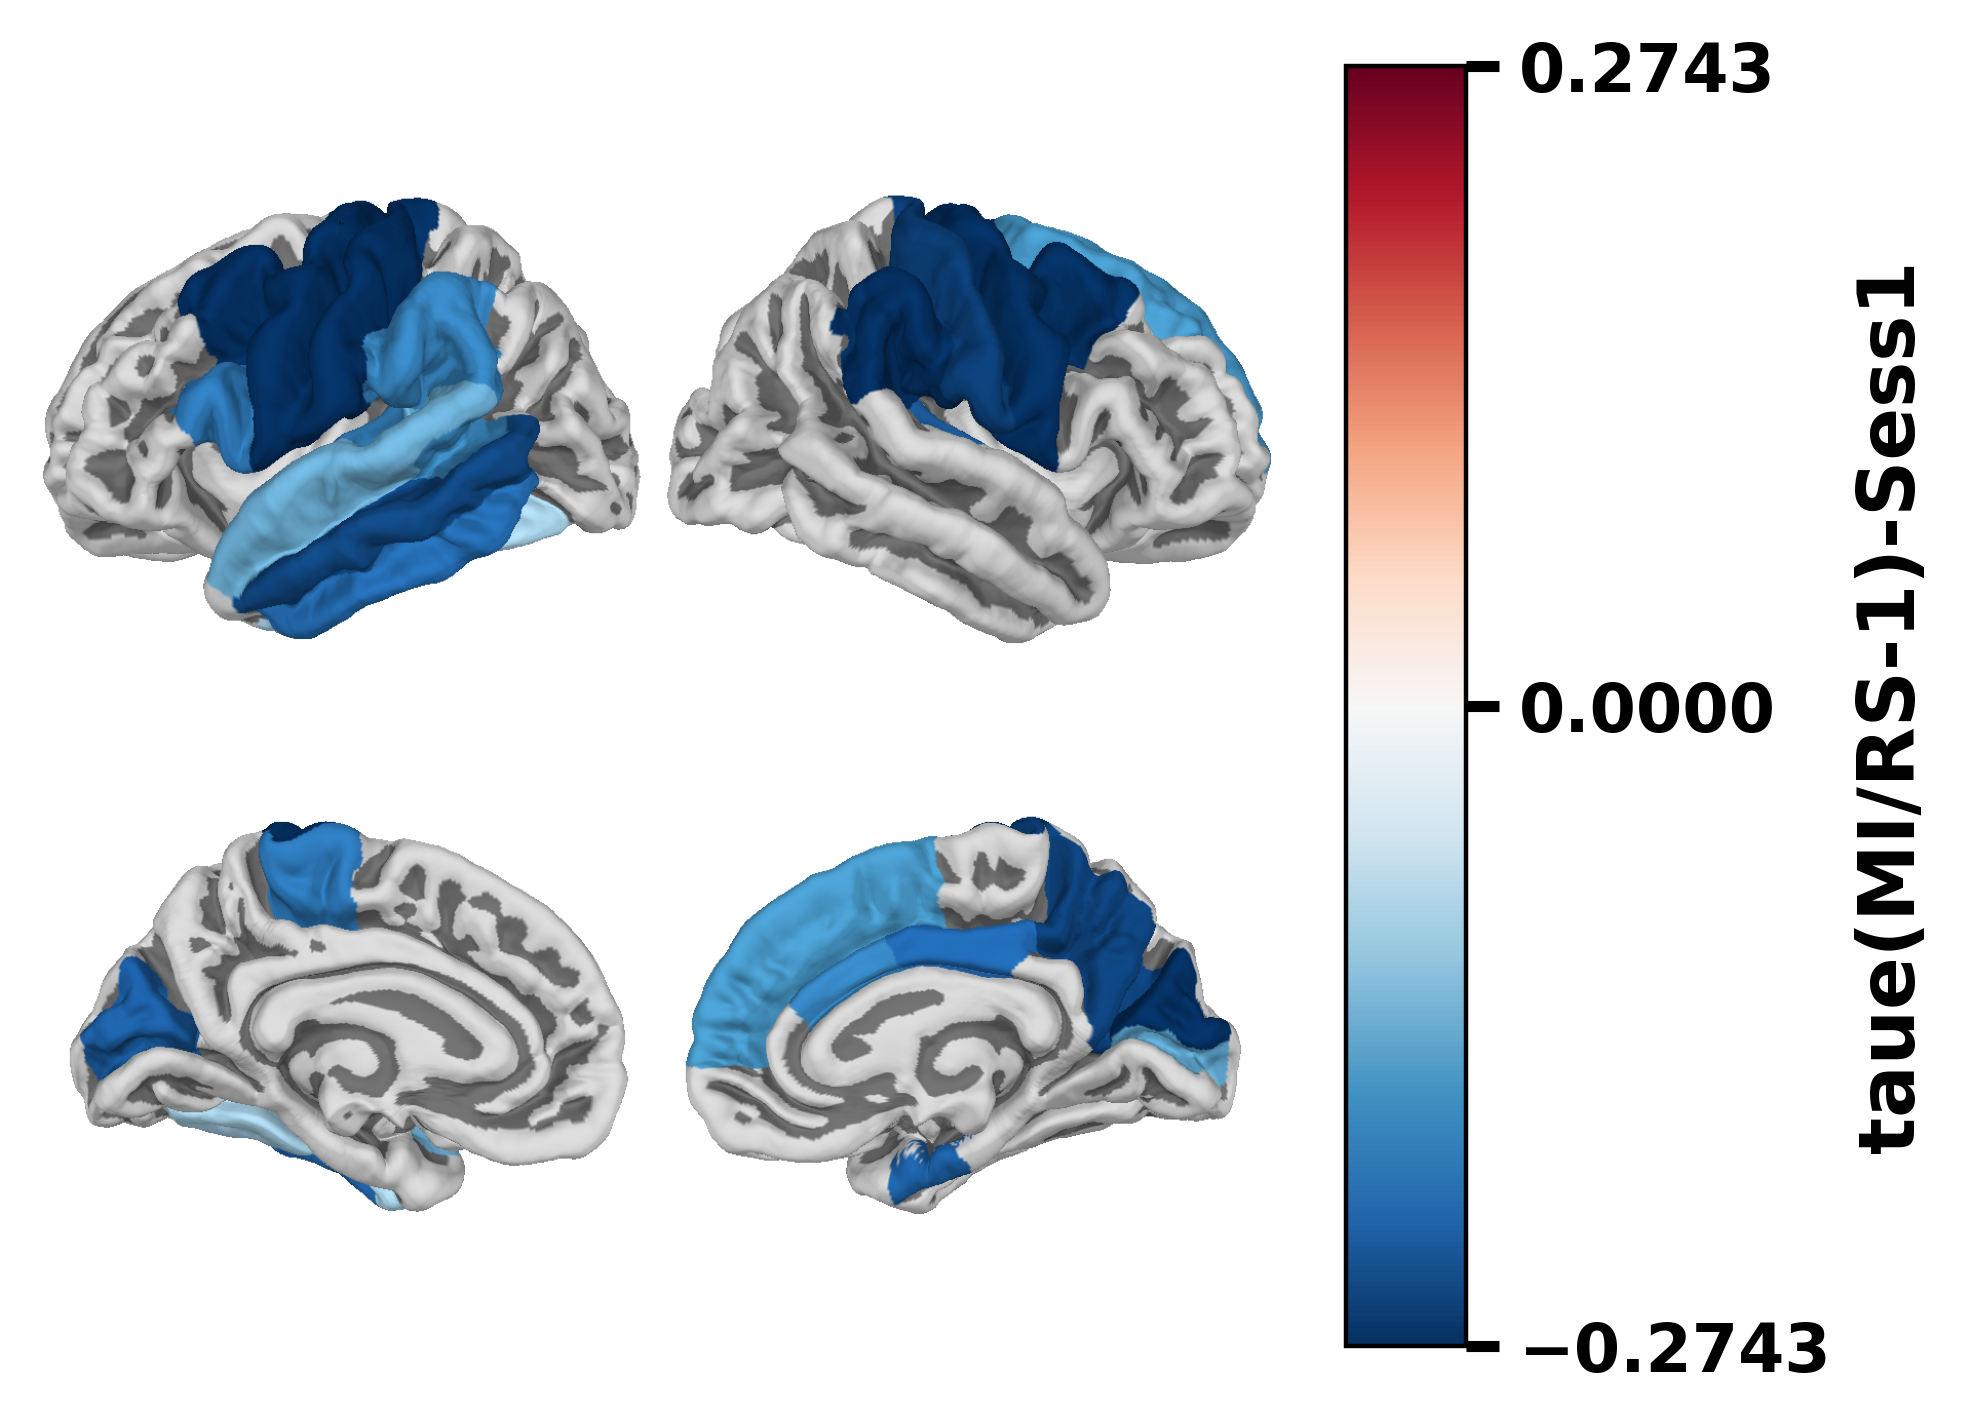

In [15]:
##brain plot with taue(MI/RS-1) values for signifant (pFDR<0.05) regions
##taue-max and min values of all sessions
max_val = df_taue[['S1', 'S2', 'S3', 'S4']].to_numpy().max()
min_val = df_taue[['S1', 'S2', 'S3', 'S4']].to_numpy().min()

##For plotting (MI/RS-1)
roi_tvalues = dict(zip(list(df_taue.index), list(df_taue['S1'])))

brain = Brain(
    subject=subject,
    subjects_dir=subjects_dir,
    surf="pial",
    hemi="split",  
    background="white",
    views=["lat", "med"],
    # views=["dorsal"],
    size=(600, 600),
    # offset='auto',
    # view_layout='horizontal',
    # show=False, 
)

cmap = cmaps.get_cmap("RdBu_r") #changing RdBu_r to RdBu to make reddish appearance for greater values
# vmin, vmax = -np.max(list(df_taue['S3'])), np.max(list(df_taue['S3']))  
vmin, vmax = -max_val, max_val # Use the max value from all sessions
norm = Normalize(vmin=vmin, vmax=vmax)

for label in labels:
    if label.name in taue_meg_sess1_regions:  
        t_value = roi_tvalues[label.name]
        rgba_color = cmap(norm(t_value))
        brain.add_label(label, color=rgba_color[:4]) 

# for label in labels:
#     if label.name in taue_meg_sess1_regions:
#         t_value = roi_tvalues[label.name]
#         if t_value < 0.05:  # Only significant
#             rgba_color = cmap(norm(t_value))
#             brain.add_label(label, color=rgba_color[:3])
#         else:
#             continue  # Skip non-significant


clim = dict(kind="value", lims=[vmin, (vmin+vmax)/2, vmax])
brain.save_image("pfdr_taue_meg_sess1.png")
#the combined plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=400) 

brain_image = plt.imread("pfdr_taue_meg_sess1.png")
ax.imshow(brain_image)
ax.axis('off')  

#vertical colorbar next to the brain image
cbar_ax = fig.add_axes([0.8, 0.1, 0.05, 0.8]) 
# [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# [0.8, 0.1, 0.05, 0.8]--vertical
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)

# Set colorbar label with larger font
cb.set_label("taue(MI/RS-1)-Sess1", fontsize=14, weight='bold')

# Set custom ticks and formatting
cb.set_ticks([vmin, (vmin + vmax) / 2, vmax])
cb.ax.tick_params(
    axis='y',
    which='both',
    length=6,       
    width=2,       
    colors='black', 
    # direction='out',
    labelsize=12    
)

# bolden each tick label
for label in cb.ax.get_yticklabels():
    label.set_fontweight('bold')

# # [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# #color bar for the brain labels
# cbar_ax = fig.add_axes([0.8, 0.1, 0.02, 0.8])  
# cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
# cb.set_label("taue(MI/RS-1)-Sess4")  
# cb.set_ticks([vmin, (vmin+vmax)/2, vmax])  


# plt.savefig(f"/Users/apurbadebnath/Desktop/iitm_project/sgm_bci_paper_figures/brain_plot_significant_taue_mi_rs_sess1.png", dpi=300)
plt.show()


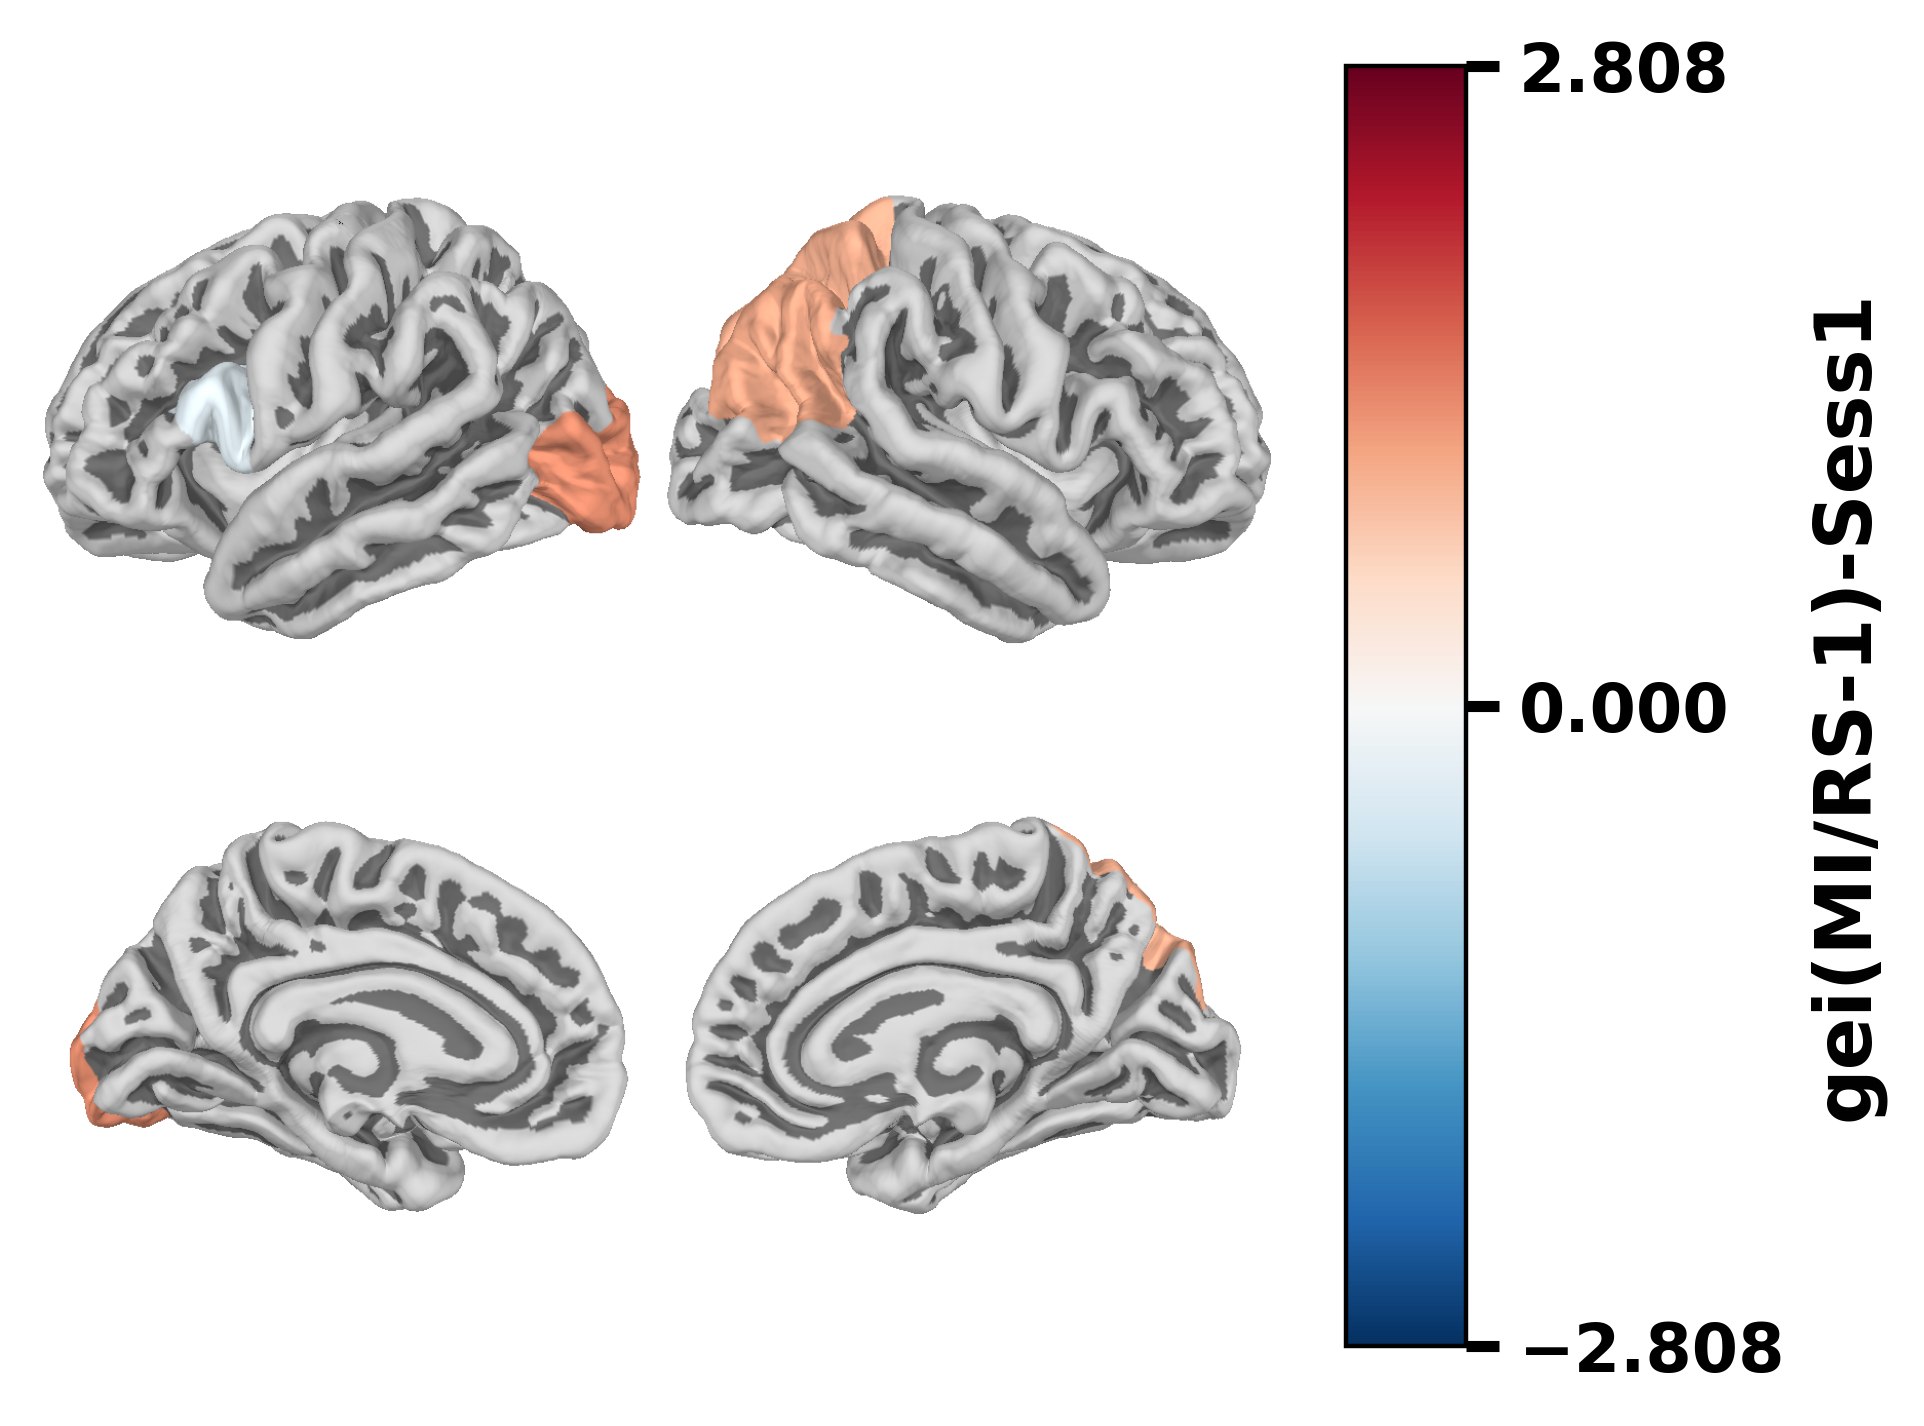

In [26]:
##brain plot with gii/gei(MI/RS-1) values for signifant (pFDR<0.05) regions
##gii/gei-max and min (MI/RS-1) values of all session
max_val = df_gei[['S1', 'S2', 'S3', 'S4']].to_numpy().max()
min_val = df_gei[['S1', 'S2', 'S3', 'S4']].to_numpy().min()

##For plotting (MI/RS-1)
roi_tvalues = dict(zip(list(df_gei.index), list(df_gei['S1'])))

brain = Brain(
    subject=subject,
    subjects_dir=subjects_dir,
    surf="pial",
    hemi="split",  
    background="white",
    views=["lat", "med"],
    # views=["dorsal"],
    size=(600, 600),
    # offset='auto',
    # view_layout='horizontal',
    # show=False, 
)

cmap = cmaps.get_cmap("RdBu_r") #changing RdBu_r to RdBu to make reddish appearance for greater values
# vmin, vmax = -np.max(list(df_gii['S3'])), np.max(list(df_gii['S3']))  
vmin, vmax = -max_val, max_val # Use the max value from all sessions
norm = Normalize(vmin=vmin, vmax=vmax)


for label in labels:
    if label.name in gei_meg_sess1_regions:  
        t_value = roi_tvalues[label.name]
        rgba_color = cmap(norm(t_value))
        brain.add_label(label, color=rgba_color[:4]) 


clim = dict(kind="value", lims=[vmin, (vmin+vmax)/2, vmax])
brain.save_image("pfdr_gei_meg_sess1.png")
#the combined plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=400) 

brain_image = plt.imread("pfdr_gei_meg_sess1.png")
ax.imshow(brain_image)
ax.axis('off')  

#vertical colorbar next to the brain image
cbar_ax = fig.add_axes([0.8, 0.1, 0.05, 0.8]) 
# [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# [0.8, 0.1, 0.05, 0.8]--vertical
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)

# Set colorbar label with larger font
cb.set_label("gei(MI/RS-1)-Sess1", fontsize=14, weight='bold')

# Set custom ticks and formatting
cb.set_ticks([vmin, (vmin + vmax) / 2, vmax])
cb.ax.tick_params(
    axis='y',
    which='both',
    length=6,       
    width=2,       
    colors='black', 
    # direction='out',
    labelsize=12    
)

# bolden each tick label
for label in cb.ax.get_yticklabels():
    label.set_fontweight('bold')

# # [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
# #color bar for the brain labels
# cbar_ax = fig.add_axes([0.8, 0.1, 0.05, 0.8])  
# cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
# cb.set_label("gei(MI/RS-1)-Sess1")  
# cb.set_ticks([vmin, (vmin+vmax)/2, vmax])  


plt.savefig(f"/Users/apurbadebnath/Desktop/iitm_project/sgm_bci_paper_figures/brain_plot_significant_gei_mi_rs_sess1.png", dpi=300)
plt.show()


In [102]:
# # Configure the colormap and limits
# clim = dict(kind="value", lims=[vmin, (vmin + vmax)/2, vmax])

# # Create a Matplotlib figure for the color bar
# fig, ax = plt.subplots(figsize=(0.4, 5), dpi=400)  

# # Plot the color bar
# plot_brain_colorbar(
#     ax=ax,
#     clim=clim,
#     colormap="gnuplot", 
#     # transparent=True,   
#     orientation="vertical", 
#     label="taue(MI/RS-1)",  
#     bgcolor="white"
# )

# # Highlight the point ticks
# ax.tick_params(
#     axis='y',          
#     which='both',      
#     length=3,          
#     width=2,           
#     # colors='black',    
#     direction='out',   
#     labelsize=10       
# )

# # Optional: make tick labels bold
# for label in ax.get_yticklabels():
#     label.set_fontweight('bold')

# # Save the color bar image
# # plt.savefig("/Users/apurbadebnath/Pictures/taue_analysis/brain_plots/colorbar_meg_taue.png", dpi=300)

# # Display the color bar
# plt.show()


In [60]:
max_val = df_gii[['S1', 'S2', 'S3', 'S4']].to_numpy().max()
min_val = df_gii[['S1', 'S2', 'S3', 'S4']].to_numpy().min()
print(max_val,min_val)

5.622360593367486 -0.5561395427479011


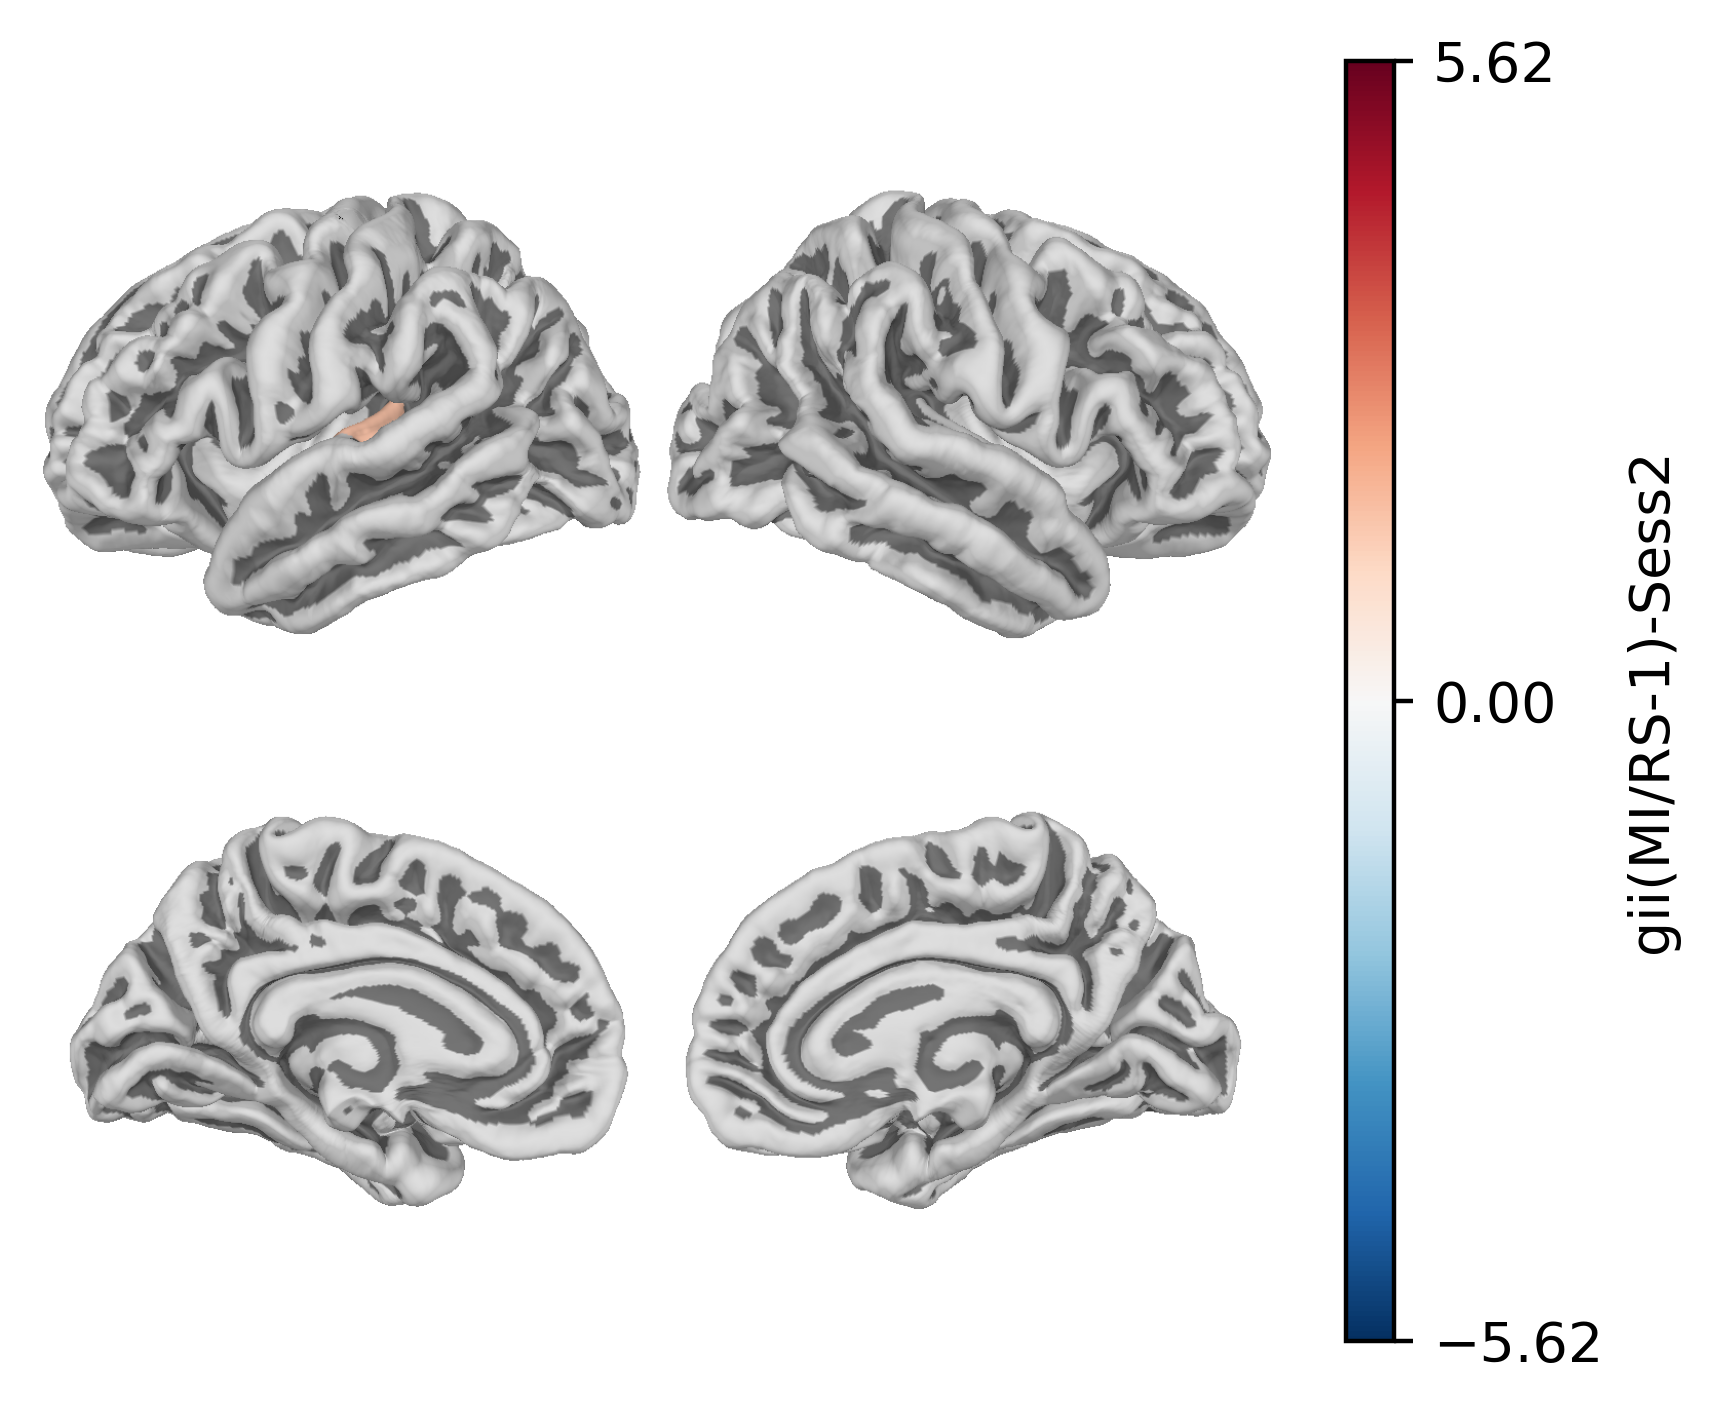

In [30]:
##brain plot with taue(MI/RS-1) values for signifant (pFDR<0.05) regions
##gii/gei
max_val = df_gii[['S1', 'S2', 'S3', 'S4']].to_numpy().max()
min_val = df_gii[['S1', 'S2', 'S3', 'S4']].to_numpy().min()

##For plotting (MI/RS-1)
roi_tvalues = dict(zip(list(df_gii.index), list(df_gii['S2'])))

brain = Brain(
    subject=subject,
    subjects_dir=subjects_dir,
    surf="pial",
    hemi="split",  
    background="white",
    views=["lat", "med"],
    # views=["dorsal"],
    size=(600, 600),
    # offset='auto',
    # view_layout='horizontal',
    # show=False, 
)

cmap = cmaps.get_cmap("RdBu_r") #changing RdBu_r to RdBu to make reddish appearance for greater values
# vmin, vmax = -np.max(list(df_gii['S3'])), np.max(list(df_gii['S3']))  
vmin, vmax = -max_val, max_val # Use the max value from all sessions
norm = Normalize(vmin=vmin, vmax=vmax)


for label in labels:
    if label.name in gii_meg_sess2_regions:  
        t_value = roi_tvalues[label.name]
        rgba_color = cmap(norm(t_value))
        brain.add_label(label, color=rgba_color[:4]) 


# for label in labels:
#     if label.name in gii_meg_sess4_regions:
#         t_value = roi_tvalues[label.name]
#         if t_value < 0.05:  # Only significant
#             rgba_color = cmap(norm(t_value))
#             brain.add_label(label, color=rgba_color[:3])
#         else:
#             continue  # Skip non-significant


clim = dict(kind="value", lims=[vmin, (vmin+vmax)/2, vmax])
brain.save_image("pfdr_gii_meg_sess2.png")
#the combined plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=400) 

brain_image = plt.imread("pfdr_gii_meg_sess2.png")
ax.imshow(brain_image)
ax.axis('off')  

# [0.15, 0.1, 0.7, 0.3]-->becomes horizontal
#color bar for the brain labels
cbar_ax = fig.add_axes([0.8, 0.1, 0.02, 0.8])  
cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
cb.set_label("gii(MI/RS-1)-Sess2")  
cb.set_ticks([vmin, (vmin+vmax)/2, vmax])  


plt.savefig(f"/Users/apurbadebnath/Desktop/iitm_project/sgm_bci_paper_figures/brain_plot_significant_gii_mi_rs_sess2.png", dpi=300)
plt.show()
